In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

# data handling and numerical analysis
import uproot
import awkward as ak
import numpy as np
import pandas as pd

import scipy

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

from Tools.config_helpers import get_samples
from Tools.HyperPoly import *
from Tools.reweighting import get_coordinates_and_ref, get_coordinates

from BoostedInformationTreeP3 import BoostedInformationTree

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils import resample, shuffle

from yahist import Hist1D

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
sample_list =  ['TTW', 'TTZ','TTH']
#years = ['2016APV', '2016', '2017', '2018']
years = ['2016APV', '2016', '2017', '2018']

In [4]:
df_bkg = pd.DataFrame()
for year in years:
    tmp = pd.concat([pd.read_hdf(f"../processor/multiclass_input_{sample}_{year}.h5") for sample in sample_list])
    df_bkg = pd.concat([df_bkg, tmp])
    df_bkg = df_bkg[df_bkg['SS']==1]
del tmp

In [5]:
df_signal = pd.read_hdf("../processor/multiclass_input_topW_2017.h5")
len(df_signal[(df_signal['SS']==1)])

26933

In [6]:
df_signal = pd.concat([pd.read_hdf(f"../processor/multiclass_input_topW_{year}.h5") for year in years])

len(df_signal[(df_signal['SS']==1)])

94140

In [7]:
len(df_signal[((df_signal['SS']==1)|((df_signal['OS']==1)&(df_signal['nLepFromTop']==1)))])

182275

In [8]:
df_signal_SS = df_signal[(df_signal['SS']==1)]
df_signal_SS_tight = df_signal[((df_signal['SS']==1)&(df_signal['nLepFromTop']==1))]
df_signal_OS = df_signal[((df_signal['OS']==1)&(df_signal['nLepFromTop']==1))]

In [9]:
len(df_signal_SS)

94140

In [10]:
len(df_signal_OS)

88135

## Double the training set size.

Check that OS with exactly one leptonic top look exactly like SS events for our variables (e.g. lepton kinematics, mll)

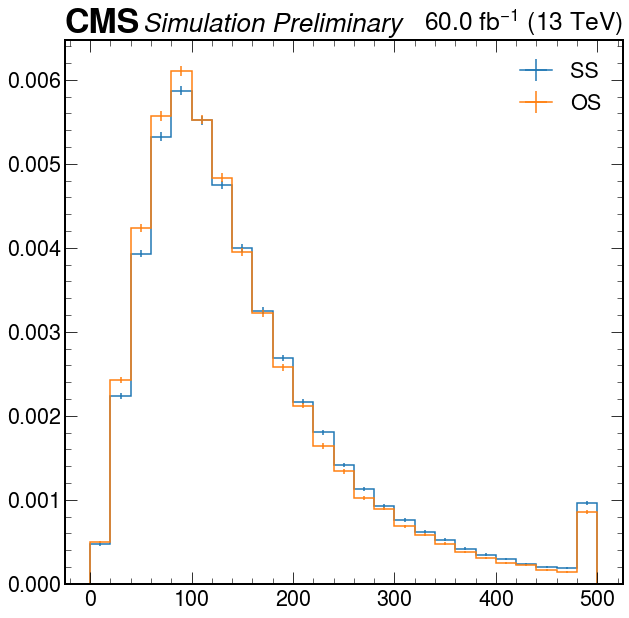

In [11]:
h_mll_SS = Hist1D(df_signal_SS['dilepton_mass'], bins="25,0,500")
h_mll_OS = Hist1D(df_signal_OS['dilepton_mass'], bins="25,0,500")

fig, ax = plt.subplots(figsize=(10,10))

hep.cms.label(
    "Preliminary",
    data=False,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [ h_mll_SS.counts, h_mll_OS.counts ],
    h_mll_SS.edges,
    w2=[ h_mll_SS.errors**2, h_mll_OS.errors**2 ],
    histtype="step",
    stack=False,
    label=['SS', 'OS'],
    density=True,
    ax=ax)

ax.legend()

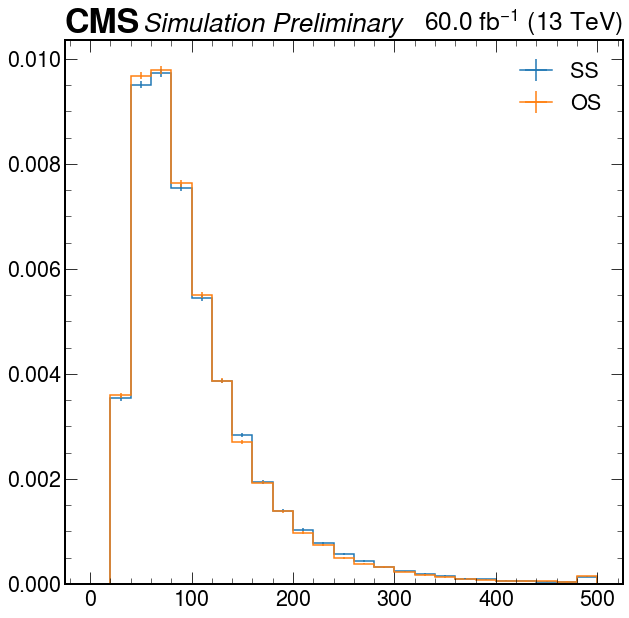

In [12]:
h_lead_lep_pt_SS = Hist1D(df_signal_SS['lead_lep_pt'], bins="25,0,500")
h_lead_lep_pt_OS = Hist1D(df_signal_OS['lead_lep_pt'], bins="25,0,500")

fig, ax = plt.subplots(figsize=(10,10))

hep.cms.label(
    "Preliminary",
    data=False,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [ h_lead_lep_pt_SS.counts, h_lead_lep_pt_OS.counts ],
    h_mll_SS.edges,
    w2=[ h_lead_lep_pt_SS.errors**2, h_lead_lep_pt_OS.errors**2 ],
    histtype="step",
    stack=False,
    label=['SS', 'OS'],
    density=True,
    ax=ax)

ax.legend()

In [13]:
df_signal[(df_signal['SS']==1)]

,n_jet,n_b,n_fwd,n_tau,st,met,mjj_max,delta_eta_jj,lead_lep_pt,lead_lep_eta,...,nLepFromTop,label,total_charge,event,cpt_0p_cpQM_0p_nlo,cpt_0p_cpQM_3p_nlo,cpt_0p_cpQM_6p_nlo,cpt_3p_cpQM_0p_nlo,cpt_6p_cpQM_0p_nlo,cpt_3p_cpQM_3p_nlo
2,8.0,3.0,0.0,0.0,1114.246302,289.113037,0.000000,0.000000,38.327999,0.324524,...,1.0,0.0,2.0,2608.0,0.999969,1.389038,2.409790,1.413452,2.464233,1.620850
3,4.0,1.0,0.0,0.0,327.285095,45.718220,0.000000,0.000000,49.893337,0.140076,...,1.0,0.0,2.0,2615.0,1.000061,0.783478,0.606445,0.920288,0.860992,0.719299
7,7.0,1.0,0.0,0.0,702.498241,38.902111,0.000000,0.000000,95.846756,-0.400818,...,1.0,0.0,-2.0,2704.0,1.000000,0.794525,0.690918,1.222351,1.551819,0.943817
19,8.0,2.0,1.0,0.0,1288.633255,189.510834,719.777649,4.405884,237.965927,-0.719849,...,1.0,0.0,2.0,3025.0,1.000732,11.596191,45.652344,8.506348,40.308594,16.655273
21,6.0,1.0,2.0,0.0,2474.528374,780.010864,1200.096191,2.662720,140.800415,-0.263733,...,1.0,0.0,2.0,3144.0,1.000000,1.140320,1.898804,1.118530,1.565613,1.240173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152189,6.0,2.0,1.0,0.0,647.432514,38.252930,357.813477,2.991302,40.573902,0.657837,...,1.0,0.0,2.0,1930.0,1.000000,0.835541,0.848236,1.228821,1.611206,0.989746
152193,5.0,1.0,1.0,0.0,705.284466,69.747154,852.537109,3.460693,55.529518,-1.418213,...,1.0,0.0,2.0,2038.0,1.000000,0.808228,0.639526,1.092224,1.205017,0.890259
152195,6.0,2.0,1.0,0.0,1438.297974,162.091919,1120.383301,4.550537,485.206940,-0.616211,...,1.0,0.0,-2.0,2152.0,0.999542,21.026367,81.687500,23.485352,83.511719,38.351562
152200,8.0,1.0,1.0,1.0,761.927658,118.772217,297.754395,2.854492,133.017838,0.512939,...,1.0,0.0,2.0,2361.0,0.999939,0.948547,1.917969,2.457397,4.940186,2.019409


In [14]:
sum(df_signal['weight'][((df_signal['SS']==1)&(df_signal['n_fwd']>=1))])

40.47814022596416

In [15]:
sum(df_signal['weight'][((df_signal['SS']==1)&(df_signal['n_fwd']>=1))]*df_signal['cpt_6p_cpQM_0p_nlo'][((df_signal['SS']==1)&(df_signal['n_fwd']>=1))])

84.39337081392881

In [16]:
sum(df_bkg['weight'][((df_bkg['SS']==1)&(df_bkg['n_fwd']>=1))])

345.77079607764

In [17]:
df_signal['cpt_0p_cpQM_0p_nlo']

0         0.999969
1         1.000000
2         0.999969
3         1.000061
4         1.000000
            ...   
152200    0.999939
152201    1.000000
152202    1.000000
152203    1.000000
152204    1.000000
Name: cpt_0p_cpQM_0p_nlo, Length: 288215, dtype: float64

# EFT inputs

We need the polynomial parametrization. Do we have them in the samples?

In [18]:
samples = get_samples("samples_UL17.yaml")

In [19]:
samples['/ceph/cms/store/user/dspitzba/ProjectMetis/TTW_5f_EFT_NLO_RunIISummer20UL17_NanoAODv9_NANO_v11/']['files']

['/ceph/cms/store/user/dspitzba/nanoAOD/ttw_samples//topW_v0.7.0_dilep/ProjectMetis_TTW_5f_EFT_NLO_RunIISummer20UL17_NanoAODv9_NANO_v11/merged/nanoSkim_2.root',
 '/ceph/cms/store/user/dspitzba/nanoAOD/ttw_samples//topW_v0.7.0_dilep/ProjectMetis_TTW_5f_EFT_NLO_RunIISummer20UL17_NanoAODv9_NANO_v11/merged/nanoSkim_1.root']

In [20]:
f_in = samples['/ceph/cms/store/user/dspitzba/ProjectMetis/TTW_5f_EFT_NLO_RunIISummer20UL17_NanoAODv9_NANO_v11/']['files'][0]

n_max = 1000
events = NanoEventsFactory.from_root(
    f_in,
    schemaclass = NanoAODSchema,
    entry_stop = n_max).events()

In [21]:
events.Pol[0]

<Array [1, 0.0389, ... -0.00451, 0.00244] type='6 * float32[parameters={"__doc__...'>

In [22]:
hp = HyperPoly(2)
    
coordinates, ref_coordinates = get_coordinates_and_ref(f_in)

ref_coordinates = [0.0,0.0]

hp.initialize( coordinates, ref_coordinates )

tree    = uproot.open(f_in)['Events']

weights = [ x.replace('LHEWeight_','') for x in tree.keys() if x.startswith('LHEWeight_c') ]

In [23]:
weights

['cpt_0p_cpQM_0p_nlo',
 'cpt_3p_cpQM_0p_nlo',
 'cpt_0p_cpQM_3p_nlo',
 'cpt_6p_cpQM_0p_nlo',
 'cpt_3p_cpQM_3p_nlo',
 'cpt_0p_cpQM_6p_nlo']

In [24]:
events.LHEWeight.cpt_0p_cpQM_0p_nlo

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1000 * float32[parameters=...'>

In [25]:
getattr(events.LHEWeight, weights[0])

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='1000 * float32[parameters=...'>

In [26]:
para = hp.get_parametrization( [getattr(events.LHEWeight, w) for w in weights] )

In [27]:
para[:,0]

array([ 0.99996948,  0.03894552, -0.04680379,  0.00247023, -0.00450643,
        0.00243802])

In [28]:
hp.root_func_string(para[:,0])

'0.999969+0.038946*x0-0.046804*x1+0.00247*x0**2-0.004506*x0*x1+0.002438*x1**2'

# Boosted Info Tree

In [29]:
df_signal['cpt_0p_cpQM_0p_nlo'].values

array([0.99996948, 1.        , 0.99996948, ..., 1.        , 1.        ,
       1.        ])

In [30]:
coeff = hp.get_parametrization( [df_signal[w].values for w in weights] )

In [31]:
hp.eval(coeff, [3.,0.])

array([1.24450684, 1.14538574, 1.41345215, ..., 1.14959717, 1.13098145,
       1.0090332 ])

We want coeffs with index 1 and 3, if I understand everything correctly here.

In [32]:
coeff[1,:]

array([ 0.07200623,  0.03689575,  0.03161112, ...,  0.04490153,
        0.03150431, -0.00357056])

In [33]:
df_signal['lt'] = (df_signal['lead_lep_pt'].values + df_signal['sublead_lep_pt'].values + df_signal['met'].values)
df_bkg['lt'] = (df_bkg['lead_lep_pt'].values + df_bkg['sublead_lep_pt'].values + df_bkg['met'].values)

# this roughly corresponds to labeling
for i in range(6):
    df_signal['coeff_%s'%i] = coeff[i,:]
    df_bkg['coeff_%s'%i] = np.zeros(len(df_bkg))

#df_signal['coeff'] = coeff.transpose()

df_signal = df_signal[((df_signal['n_fwd']>=1))]
df_bkg = df_bkg[((df_bkg['SS']==1)&(df_bkg['n_fwd']>=1))]

# signal

sig_train_sel = ((df_signal['OS']==1) & (df_signal['nLepFromTop']==1)) #((df_signal['event']%2)==1).values
sig_test_sel = (df_signal['SS']==1)#~sig_train_sel

sig_train = df_signal[sig_train_sel]
sig_test = df_signal[sig_test_sel]

# bkg

bkg_train_sel = (df_bkg['event']%2)==1
bkg_test_sel = ~bkg_train_sel

#bkg_train = resample(df_bkg[bkg_train_sel], n_samples=len(sig_train))
bkg_train = df_bkg[bkg_train_sel]
bkg_test = df_bkg[bkg_test_sel]


train = pd.concat([sig_train, bkg_train])
#train['weight'] = abs(train['weight'])

train = shuffle(train)


variables = [
        'n_jet',
        'n_fwd',
        'n_b',
        'n_tau',
        'st',
        'lt',
        'met',
        'mjj_max',
        'delta_eta_jj',
        'lead_lep_pt',
        'lead_lep_eta',
        'sublead_lep_pt',
        'sublead_lep_eta',
        'dilepton_mass',
        'dilepton_pt',
        'fwd_jet_pt',
        'fwd_jet_p',
        'fwd_jet_eta',
        'lead_jet_pt',
        'sublead_jet_pt',
        'lead_jet_eta',
        'sublead_jet_eta',
        'lead_btag_pt',
        'sublead_btag_pt',
        'lead_btag_eta',
        'sublead_btag_eta',
        'min_bl_dR',
        'min_mt_lep_met',
    ]

variables = sorted(variables)


In [34]:
sum(sig_train['weight'])

37.92277024104598

In [35]:
sum(bkg_train['weight'])

173.22553047099163

In [43]:
Hist1D(coeff[3,:], bins="100,-0.1,0.1")

[ 2.00 ± 1.41    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    2.00 ± 1.41    1.00 ± 1.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    1.00 ± 1.00
  3.00 ± 1.73    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    4.00 ± 2.00
  6.00 ± 2.45    9.00 ± 3.00    3.00 ± 1.73    3.00 ± 1.73    0.00 ± 0.00
  7.00 ± 2.65    8.00 ± 2.83   21.00 ± 4.58   44.00 ± 6.63
 242.00 ± 15.56   84160.00 ± 290.10   63804.00 ± 252.59
 32057.00 ± 179.04   19667.00 ± 140.24   13396.00 ± 115.74
 9943.00 ± 99.71   7360.00 ± 85.79   5905.00 ± 76.84   4946.00 ± 70.33
 3959.00 ± 62.92   3392.00 ± 58.24   2923.00 ± 54.06   2570.00 ± 50.70
 2187.00 ± 46.77   1893.00 ± 43.51   1817.00 ± 42.63   1550.00 ± 39.37
 1358.00 ± 36.85   1251.00 ± 35.37   1137.00 ± 33.72   1015.00 ± 31.86
 938.00 ± 30.63   892.00 ± 29.87   784.00 ± 28.00   785.00 ± 28.02
 733.00 ± 27.07   631.00 ± 25.12   610.00 ± 24.70   577.00 ± 24.02
 565.00 ± 23.77   490.00 ± 22.14   491.00 ± 22.16   455.00 ± 21.33
 445.00 ± 21.10   368.00 ± 19.18   372.00 ± 19.29   361.00 ± 19.00
 295.00 ± 17.18   357.00 ± 18.89   283.00 ± 16.82   288.00 ± 16.97
 256.00 ± 16.00   254.00 ± 15.94   242.00 ± 15.56   214.00 ± 14.63
 243.00 ± 15.59   261.00 ± 16.16   237.00 ± 15.39   197.00 ± 14.04
 8945.00 ± 94.58]

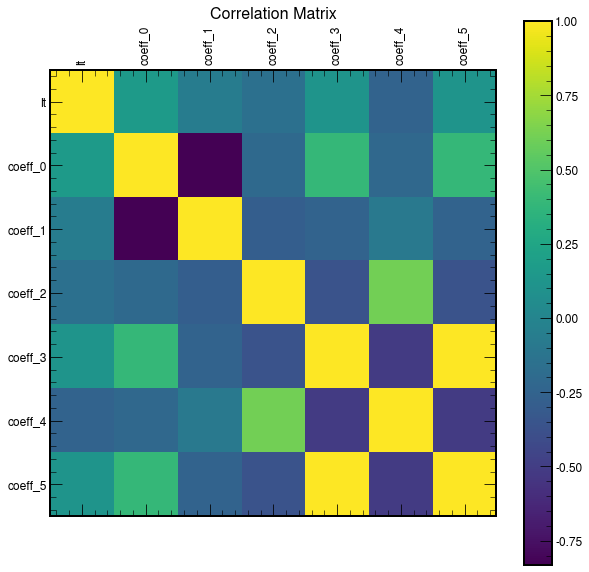

In [94]:
from ML.multiclassifier_tools import get_correlation_matrix, get_confusion_matrix
plot_dir = '/home/users/dspitzba/public_html/tW_scattering/BIT/'

get_correlation_matrix(
    df_signal[['lt', 'coeff_0', 'coeff_1', 'coeff_2', 'coeff_3', 'coeff_4', 'coeff_5']], 
    f_out=plot_dir+'/correlation.png'
)


In [95]:
df_signal[['coeff_3', 'coeff_5']]

,coeff_3,coeff_5
1,0.003855,0.003991
5,0.007155,0.006721
6,0.005546,0.005485
8,0.002051,0.002743
9,0.005191,0.005851
...,...,...
82953,0.001684,0.001675
82955,0.003961,0.005113
82956,0.001129,0.001139
82957,0.058811,0.059611


In [44]:
h_0 = Hist1D(df_signal['lt'], weights=df_signal['weight'], bins="20,100,500")

In [45]:
inputs = [np.expand_dims(df_signal['coeff_%s'%i], axis=1) for i in range(6)]

coeffs = np.concatenate(inputs, axis=1)

In [46]:
h_1 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [1.,0.]), bins="20,100,500")
h_2 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [2.,0.]), bins="20,100,500")
h_3 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [3.,0.]), bins="20,100,500")
h_4 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [4.,0.]), bins="20,100,500")
h_5 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [5.,0.]), bins="20,100,500")
h_6 = Hist1D(df_signal['lt'], weights=df_signal['weight']*hp.eval(coeffs.transpose(), [6.,0.]), bins="20,100,500")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d970f7d90>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d970f7b50>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d970f7a60>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d97560700>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d972310a0>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d97231a60>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f4d97231ca0>, errorbar=None, legend_artist=None)]

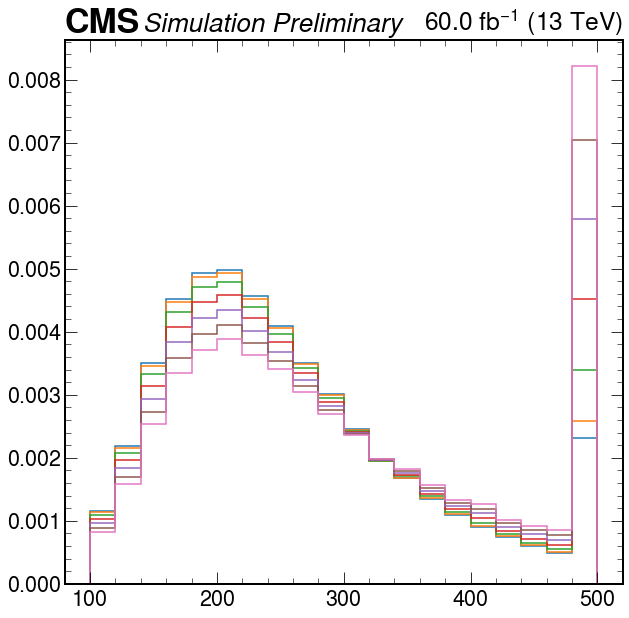

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
#, gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)

hep.cms.label(
    "Preliminary",
    data=False,
    #year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [ h_0.counts, h_1.counts, h_2.counts, h_3.counts, h_4.counts, h_5.counts, h_6.counts ],
    h_0.edges,
    #w2=[ my_histos[x].errors for x in keys ],
    histtype="step",
    stack=False,
    #label=['%s (%.0f)'%(my_histos[x].label, sum(my_histos[x].counts)) for x in keys],
    #color=[ my_histos[x].color for x in keys ],
    density=True,
    ax=ax)

In [48]:
sum(hp.eval(coeff.transpose()[sig_train_sel].transpose(), [6,0]))/len(train['weight'])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 288215 but corresponding boolean dimension is 195076

In [46]:
sum(coeff[1,:][sig_train_sel]*6)/len(sig_train['weight'])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 136010 but corresponding boolean dimension is 29107

In [34]:
sum(coeff[3,:][sig_train_sel]*6**2)/len(sig_train['weight'])

0.7112080128177483

In [47]:
hp.root_func_string(coeff[:,0])

'0.999969+0.072006*x0-0.092809*x1+0.003169*x0**2-0.004093*x0*x1+0.002836*x1**2'

In [48]:
len(coeff[1,:])

288215

In [50]:
len(sig_test)

62384

In [48]:
sig_train['weight'].values*1000

array([1.13179645, 0.99800097, 0.90287548, ..., 0.60611645, 0.71356736,
       0.71052899])

In [45]:
n_trees       = 50
learning_rate = 0.3
max_depth     = 2
min_size      = 20
calibrated    = False

#scaler = RobustScaler()
#train_scaled = scaler.fit_transform(sig_train[variables])
#params = scaler.get_params()

train_scaled = sig_train[variables].values

bit = BoostedInformationTree(
        training_features     = train_scaled,
        #training_weights      = abs(sig_train['weight'].values),
        training_weights      = abs(sig_train['weight'].values),
        #training_weights      = np.ones(len(sig_train['weight'].values)),
        training_diff_weights = sig_train['coeff_1'].values,# coeff[3,:][sig_train_sel],
        #mva_variables         = variables,
        learning_rate         = learning_rate, 
        n_trees               = n_trees,
        max_depth             = max_depth,
        min_size              = min_size,
        calibrated            = True)

bit.boost()

[                    ----------]
weak learner time: 25.65
update time: 2.08
calibration time: 0.05


In [268]:
sum(sig_train['weight'])

37.92277024104598

In [269]:
len(sig_train)

58589

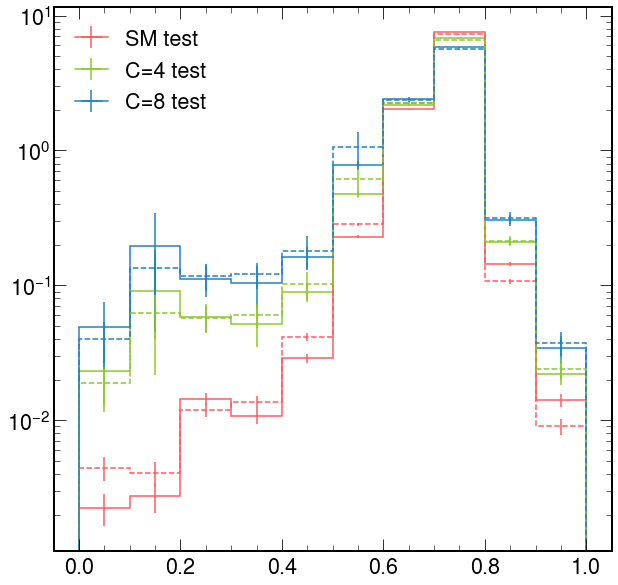

In [52]:
bins = "10,0.0,1.0"

#sig_test_scaled = scaler.transform(sig_test[variables].values)
sig_test_scaled = sig_test[variables].values
#sig_train_scaled = scaler.transform(sig_train[variables].values)
sig_train_scaled = sig_train[variables].values
                                   
coeffs = np.concatenate([np.expand_dims(sig_test['coeff_%s'%i], axis=1) for i in range(6)], axis=1)
pred = bit.vectorized_predict(sig_test_scaled)

h = Hist1D(pred, bins=bins)
h_rew = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [4.,0.]), bins=bins)
h_rew2 = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [8.,0.]), bins=bins)

coeffs_train = np.concatenate([np.expand_dims(sig_train['coeff_%s'%i], axis=1) for i in range(6)], axis=1)
pred_train = bit.vectorized_predict(sig_train_scaled)

h_train = Hist1D(pred_train, bins=bins)
h_rew_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [4.,0.]), bins=bins)
h_rew2_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [8.,0.]), bins=bins)

fig, ax = plt.subplots(figsize=(10,10))

# solid - testing
hep.histplot(
    [ h.counts, h_rew.counts, h_rew2.counts ],
    h.edges,
    w2 = [ h.errors**2, h_rew.errors**2, h_rew2.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    label = ["SM test", "C=4 test", "C=8 test"],
    color = ["#FF595E", "#8AC926", "#1982C4"],
    ax=ax)

# dashed - training
hep.histplot(
    [ h_train.counts, h_rew_train.counts, h_rew2_train.counts ],
    h.edges,
    w2 = [ h_train.errors**2, h_rew_train.errors**2, h_rew2_train.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    #label=["SM train", "C=4 train", "C=8 train"],
    linestyle="--",
    color = ["#FF595E", "#8AC926", "#1982C4"],
    ax=ax)

ax.set_yscale('log')
ax.legend()

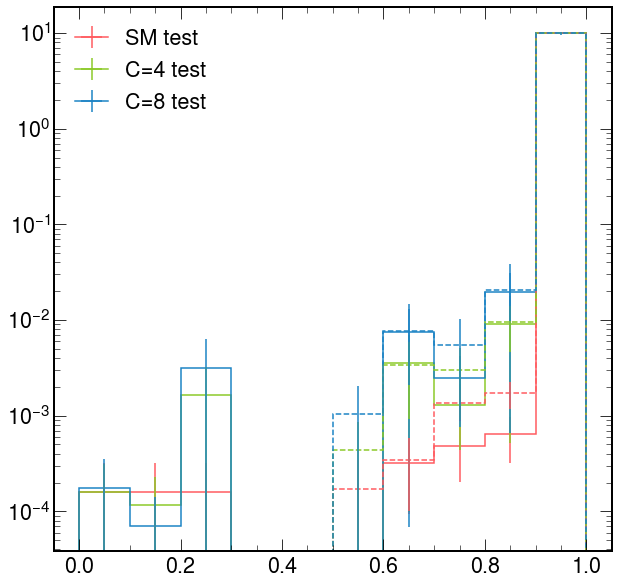

In [56]:
from scipy.special import expit

bins = "10,0.0,1.0"

coeffs = np.concatenate([np.expand_dims(sig_test['coeff_%s'%i], axis=1) for i in range(6)], axis=1)
pred = expit(25*bit.vectorized_predict(sig_test_scaled))

h = Hist1D(pred, bins=bins)
h_rew = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [4.,0.]), bins=bins)
h_rew2 = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [8.,0.]), bins=bins)

coeffs_train = np.concatenate([np.expand_dims(sig_train['coeff_%s'%i], axis=1) for i in range(6)], axis=1)
pred_train = expit(25*bit.vectorized_predict(sig_train_scaled))

h_train = Hist1D(pred_train, bins=bins)
h_rew_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [4.,0.]), bins=bins)
h_rew2_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [8.,0.]), bins=bins)

fig, ax = plt.subplots(figsize=(10,10))

# solid - testing
hep.histplot(
    [ h.counts, h_rew.counts, h_rew2.counts ],
    h.edges,
    w2 = [ h.errors**2, h_rew.errors**2, h_rew2.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    label = ["SM test", "C=4 test", "C=8 test"],
    color = ["#FF595E", "#8AC926", "#1982C4"],
    ax=ax)

# dashed - training
hep.histplot(
    [ h_train.counts, h_rew_train.counts, h_rew2_train.counts ],
    h.edges,
    w2 = [ h_train.errors**2, h_rew_train.errors**2, h_rew2_train.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    #label=["SM train", "C=4 train", "C=8 train"],
    linestyle="--",
    color = ["#FF595E", "#8AC926", "#1982C4"],
    ax=ax)

ax.set_yscale('log')
ax.legend()

In [64]:
h.counts

array([5.0000e+00, 1.0000e+00, 2.9000e+01, 1.9900e+02, 5.8288e+04,
       1.6670e+03, 1.0920e+03, 4.0300e+02, 1.5100e+02, 5.4900e+02])

In [65]:
h_train.counts

array([2.0000e+00, 1.0000e+00, 4.7000e+01, 2.8700e+02, 5.4702e+04,
       1.5140e+03, 1.0650e+03, 3.7600e+02, 1.5500e+02, 4.4000e+02])

In [142]:
n_trees       = 50
learning_rate = 0.5
max_depth     = 2
min_size      = 20

training_features = train[variables].values
training_weights = abs(train['weight'].values)
#training_weights = train['weight'].values  # This does absolutely not work
scaler = RobustScaler()
training_features_scaled = scaler.fit_transform(training_features)
params = scaler.get_params()

bits = []

for i in range(6):
    training_diff_weights = train['coeff_%s'%i].values
    bits.append(
        BoostedInformationTree(
            training_features     = training_features_scaled,
            training_weights      = training_weights, 
            training_diff_weights = training_diff_weights, 
            learning_rate         = learning_rate, 
            n_trees               = n_trees,
            max_depth             = max_depth,
            min_size              = min_size,
            calibrated            = True)
    )

    bits[-1].boost()

[                    ----------]
weak learner time: 151.54
update time: 10.72
calibration time: 0.26
[                    ----------]
weak learner time: 147.98
update time: 10.48
calibration time: 0.21
[                    ----------]
weak learner time: 147.87
update time: 10.74
calibration time: 0.23
[                    ----------]
weak learner time: 149.17
update time: 10.46
calibration time: 0.15
[                    ----------]
weak learner time: 154.58
update time: 11.00
calibration time: 0.21
[                    ----------]
weak learner time: 165.22
update time: 11.67
calibration time: 0.68


In [143]:
coeffs = np.concatenate([np.expand_dims(sig_test['coeff_%s'%i], axis=1) for i in range(6)], axis=1)
coeffs_train = np.concatenate([np.expand_dims(sig_train['coeff_%s'%i], axis=1) for i in range(6)], axis=1)

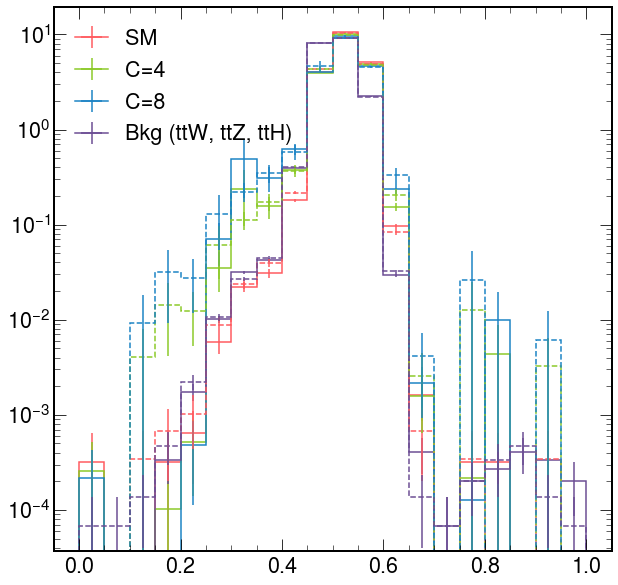

In [146]:
bins = "20,0.0,1.0"
#bins = "40,0.0,0.2"
#bins = [0.,0.4,0.6,0.8,1.7]

pred = bits[1].vectorized_predict(scaler.transform(sig_test[variables].values))
h = Hist1D(pred, bins=bins)
h_rew = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [4.,0.]), bins=bins)
h_rew2 = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [8.,0.]), bins=bins)

pred_bkg = bits[1].vectorized_predict(scaler.transform(bkg_test[variables].values))
h_ttw = Hist1D(pred_bkg, bins=bins)

bkg_test['pred'] = pred_bkg

pred_train = bits[1].vectorized_predict(scaler.transform(sig_train[variables].values))
h_train = Hist1D(pred_train, bins=bins)
h_rew_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [4.,0.]), bins=bins)
h_rew2_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [8.,0.]), bins=bins)

pred_bkg = bits[1].vectorized_predict(scaler.transform(bkg_train[variables].values))
h_ttw_train = Hist1D(pred_bkg, bins=bins)


fig, ax = plt.subplots(figsize=(10,10))

hep.histplot(
    [ h.counts, h_rew.counts, h_rew2.counts, h_ttw.counts ],
    h.edges,
    w2=[ h.errors**2, h_rew.errors**2, h_rew2.errors**2, h_ttw.errors**2 ],
    histtype="step",
    stack=False,
    label=['SM', 'C=4', 'C=8', 'Bkg (ttW, ttZ, ttH)'],
    density=True,
    color = ["#FF595E", "#8AC926", "#1982C4", "#6A4C93"],
    ax=ax)

hep.histplot(
    [ h_train.counts, h_rew_train.counts, h_rew2_train.counts, h_ttw_train.counts ],
    h.edges,
    w2 = [ h_train.errors**2, h_rew_train.errors**2, h_rew2_train.errors**2, h_ttw_train.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    linestyle="--",
    color = ["#FF595E", "#8AC926", "#1982C4", "#6A4C93"],
    ax=ax)

ax.set_yscale('log')
ax.legend()

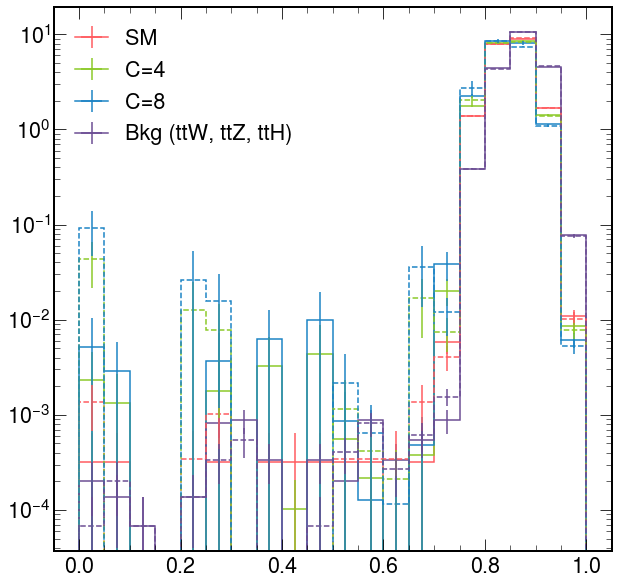

In [147]:
bins = "20,0.0,1.0"
#bins = "40,0.0,0.2"
#bins = [0.,0.4,0.6,0.8,1.7]

pred = bits[2].vectorized_predict(scaler.transform(sig_test[variables].values))
h = Hist1D(pred, bins=bins)
h_rew = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [4.,0.]), bins=bins)
h_rew2 = Hist1D(pred, weights=hp.eval(coeffs.transpose(), [8.,0.]), bins=bins)

pred_bkg = bits[2].vectorized_predict(scaler.transform(bkg_test[variables].values))
h_ttw = Hist1D(pred_bkg, bins=bins)

bkg_test['pred'] = pred_bkg

pred_train = bits[2].vectorized_predict(scaler.transform(sig_train[variables].values))
h_train = Hist1D(pred_train, bins=bins)
h_rew_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [4.,0.]), bins=bins)
h_rew2_train = Hist1D(pred_train, weights=hp.eval(coeffs_train.transpose(), [8.,0.]), bins=bins)

pred_bkg = bits[2].vectorized_predict(scaler.transform(bkg_train[variables].values))
h_ttw_train = Hist1D(pred_bkg, bins=bins)


fig, ax = plt.subplots(figsize=(10,10))

hep.histplot(
    [ h.counts, h_rew.counts, h_rew2.counts, h_ttw.counts ],
    h.edges,
    w2=[ h.errors**2, h_rew.errors**2, h_rew2.errors**2, h_ttw.errors**2 ],
    histtype="step",
    stack=False,
    label=['SM', 'C=4', 'C=8', 'Bkg (ttW, ttZ, ttH)'],
    density=True,
    color = ["#FF595E", "#8AC926", "#1982C4", "#6A4C93"],
    ax=ax)

hep.histplot(
    [ h_train.counts, h_rew_train.counts, h_rew2_train.counts, h_ttw_train.counts ],
    h.edges,
    w2 = [ h_train.errors**2, h_rew_train.errors**2, h_rew2_train.errors**2, h_ttw_train.errors**2 ],
    histtype="step",
    stack=False,
    density=True,
    linestyle="--",
    color = ["#FF595E", "#8AC926", "#1982C4", "#6A4C93"],
    ax=ax)

ax.set_yscale('log')
ax.legend()

In [152]:
def get_pred(bits, values, wc=0):
    return (
        bits[1].vectorized_predict(values) +\
        0.5*wc*bits[3].vectorized_predict(values)
    )

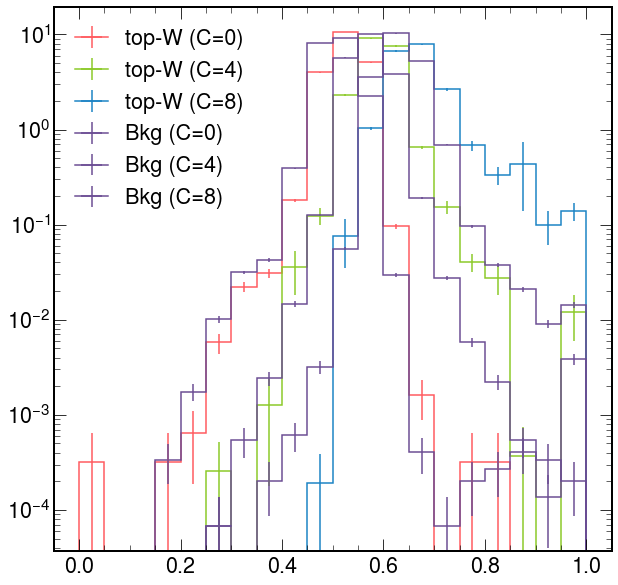

In [153]:
bins = "20,0.0,1.0"
#bins = "40,0.0,0.2"
#bins = [0.,0.4,0.6,0.8,1.7]

scaled_test = scaler.transform(sig_test[variables].values)
scaled_bkg_test = scaler.transform(bkg_test[variables].values)

for i in range(6):
    sig_test['pred_%s'%i] = bits[i].vectorized_predict(scaled_test)
    bkg_test['pred_%s'%i] = bits[i].vectorized_predict(scaled_bkg_test)


h = Hist1D(sig_test['pred_1'] + 0.5 * 0 * sig_test['pred_3'], bins=bins)
h_rew = Hist1D(sig_test['pred_1'] + 0.5 * 4 * sig_test['pred_3'], weights=hp.eval(coeffs.transpose(), [4.,0.]), bins=bins)
h_rew2 = Hist1D(sig_test['pred_1'] + 0.5 * 8 * sig_test['pred_3'], weights=hp.eval(coeffs.transpose(), [8.,0.]), bins=bins)

h_ttw = Hist1D(bkg_test['pred_1'] + 0.5 * 0 * bkg_test['pred_3'], bins=bins)
h_ttw_4 = Hist1D(bkg_test['pred_1'] + 0.5 * 4 * bkg_test['pred_3'], bins=bins)
h_ttw_8 = Hist1D(bkg_test['pred_1'] + 0.5 * 8 * bkg_test['pred_3'], bins=bins)


fig, ax = plt.subplots(figsize=(10,10))

hep.histplot(
    [ h.counts, h_rew.counts, h_rew2.counts, h_ttw.counts, h_ttw_4.counts, h_ttw_8.counts ],
    h.edges,
    w2=[ h.errors**2, h_rew.errors**2, h_rew2.errors**2, h_ttw.errors**2, h_ttw_4.errors**2, h_ttw_8.errors**2 ],
    histtype="step",
    stack=False,
    label=['top-W (C=0)', 'top-W (C=4)', 'top-W (C=8)', 'Bkg (C=0)', 'Bkg (C=4)', 'Bkg (C=8)'],
    density=True,
    color = ["#FF595E", "#8AC926", "#1982C4", "#6A4C93", "#6A4C93", "#6A4C93"],
    ax=ax)

ax.set_yscale('log')
ax.legend()

# Simplified analysis

In [154]:
df_bkg['label']

0         1.0
1         1.0
19        1.0
21        1.0
22        1.0
         ... 
412828    3.0
412833    3.0
412835    3.0
412850    3.0
412853    3.0
Name: label, Length: 590693, dtype: float64

In [155]:
ttW = bkg_test[bkg_test['label']==1]
ttZ = bkg_test[bkg_test['label']==2]
ttH = bkg_test[bkg_test['label']==3]

lt_bins = "7,100,800"
h_ttW_lt = Hist1D(ttW['lt'].values, weights=ttW['weight']*2, bins=lt_bins)
h_ttZ_lt = Hist1D(ttZ['lt'].values, weights=ttZ['weight']*2, bins=lt_bins)
h_ttH_lt = Hist1D(ttH['lt'].values, weights=ttH['weight']*2, bins=lt_bins)
h_sig_lt = Hist1D(sig_test['lt'], weights=sig_test['weight']*hp.eval(coeffs.transpose(), [5.,0.]), bins=lt_bins)
h_sig_lt_10 = Hist1D(sig_test['lt'], weights=sig_test['weight']*hp.eval(coeffs.transpose(), [10.,0.]), bins=lt_bins)

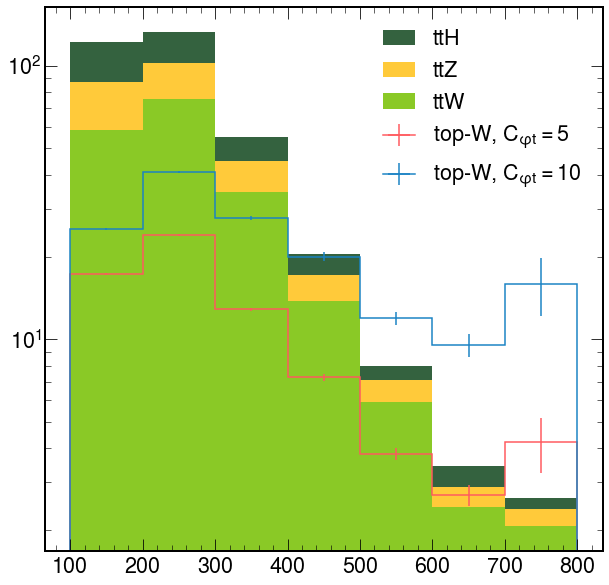

In [156]:
from plots.helpers import colors

fig, ax = plt.subplots(figsize=(10,10))

hep.histplot(
    [ h_ttW_lt.counts, h_ttZ_lt.counts, h_ttH_lt.counts ],
    h_ttW_lt.edges,
    w2=[ h_ttW_lt.errors**2, h_ttZ_lt.errors**2, h_ttH_lt.errors**2 ],
    histtype="fill",
    stack=True,
    label=['ttW', 'ttZ', 'ttH'],
    #density=True,
    color = [colors['TTW'], colors['TTZ'], colors['TTH']],
    ax=ax)

hep.histplot(
    [ h_sig_lt.counts, h_sig_lt_10.counts ],
    h_sig_lt.edges,
    w2=[ h_sig_lt.errors**2, h_sig_lt_10.errors**2 ],
    histtype="step",
    stack=False,
    label=[r'top-W, $C_{\varphi t}=5$', r'top-W, $C_{\varphi t}=10$'],
    color = [colors['tW_scattering'], colors['ttbar']],
    ax=ax)

ax.set_yscale('log')
ax.legend()

In [159]:
#bit_bins = "4,0,0.4"
#bit_bins = [0.,0.05,0.10,0.35,0.7]  # for quadratic
bit_bins = [0.,0.035,0.05,0.075,0.10,0.15,0.4]  # for quadratic with 2018 included
#bit_bins = [0.,0.4,0.6,0.8,1.7]  # for linear
#bit_bins = [0., 0.35, 0.45, 0.50, 0.55, 0.60, 1.0] # for linear with 2018 included
h_ttW_bit = Hist1D(ttW['pred_3'].values, weights=ttW['weight']*2, bins=bit_bins)
h_ttZ_bit = Hist1D(ttZ['pred_3'].values, weights=ttZ['weight']*2, bins=bit_bins)
h_ttH_bit = Hist1D(ttH['pred_3'].values, weights=ttH['weight']*2, bins=bit_bins)
h_sig_bit = Hist1D(sig_test['pred_3'], weights=sig_test['weight']*hp.eval(coeffs.transpose(), [5.,0.]), bins=bit_bins)
h_sig_bit_10 = Hist1D(sig_test['pred_3'], weights=sig_test['weight']*hp.eval(coeffs.transpose(), [10.,0.]), bins=bit_bins)

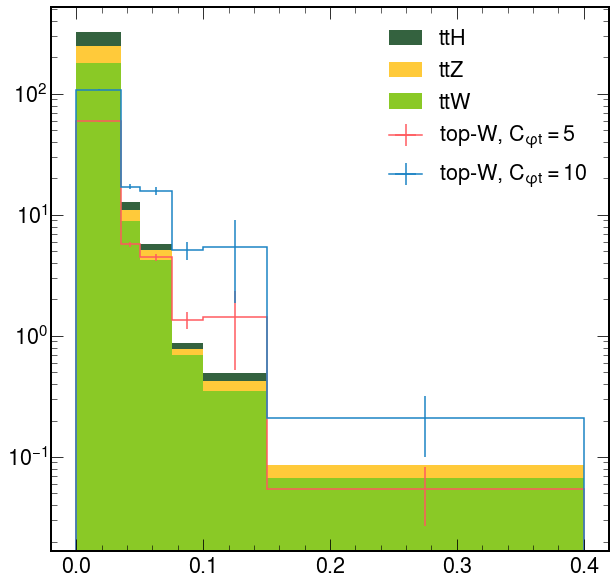

In [160]:
fig, ax = plt.subplots(figsize=(10,10))

hep.histplot(
    [ h_ttW_bit.counts, h_ttZ_bit.counts, h_ttH_bit.counts ],
    h_ttW_bit.edges,
    w2=[ h_ttW_bit.errors**2, h_ttZ_bit.errors**2, h_ttH_bit.errors**2 ],
    histtype="fill",
    stack=True,
    label=['ttW', 'ttZ', 'ttH'],
    #density=True,
    color = [colors['TTW'], colors['TTZ'], colors['TTH']],
    ax=ax)

hep.histplot(
    [ h_sig_bit.counts, h_sig_bit_10.counts ],
    h_sig_bit.edges,
    w2=[ h_sig_bit.errors**2, h_sig_bit_10.errors**2 ],
    histtype="step",
    stack=False,
    label=[r'top-W, $C_{\varphi t}=5$', r'top-W, $C_{\varphi t}=10$'],
    color = [colors['tW_scattering'], colors['ttbar']],
    ax=ax)

ax.set_yscale('log')
ax.legend()

## Running combine

In [132]:
from coffea import hist

from Tools.limits import get_unc, get_pdf_unc, get_scale_unc, makeCardFromHist
from Tools.dataCard import dataCard

card = dataCard(releaseLocation=os.path.expandvars('/home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))

In [209]:
dataset_axis = hist.Cat("dataset", "Primary dataset")
lt_axis      = hist.Bin("lt",      r"$L_{T}$ (GeV)",   [100,200,300,400,500,600,700,2000])
#bit_axis     = hist.Bin("bit",     r"BIT score",  [0.,0.05,0.10,0.35,0.7])
# [0.,0.04,0.06,0.08,0.10,0.15,0.4]
#bit_axis     = hist.Bin("bit",     r"BIT score",  [0.,0.035,0.05,0.075,0.10,0.15,0.4])
#bit_axis     = hist.Bin("bit",     r"BIT score",  [0.,0.35,0.45,0.50,0.55,0.60,1.0])
#bit_axis = hist.Bin("bit", r"BIT score",  [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1.0])
#bit_axis     = hist.Bin("bit",     r"BIT score",  [0.,0.4,0.6,0.8,1.5])

### Classical - LT

In [134]:
lt_hist = hist.Hist("lt", dataset_axis, lt_axis)
lt_hist.fill(dataset="TTW", lt=ttW['lt'].values, weight=ttW['weight']*2)
lt_hist.fill(dataset="TTZ", lt=ttZ['lt'].values, weight=ttZ['weight']*2)
lt_hist.fill(dataset="TTH", lt=ttH['lt'].values, weight=ttH['weight']*2)

hist_dict = {'SR': lt_hist}

sig_lt_hist_SM = hist.Hist("lt", dataset_axis, lt_axis)
sig_lt_hist_SM.fill(dataset='signal', lt=sig_test['lt'].values, weight=sig_test['weight'])

sig_lt_hist_BSM = hist.Hist("lt", dataset_axis, lt_axis)
sig_lt_hist_BSM.fill(dataset='signal', lt=sig_test['lt'].values, weight=sig_test['weight']*hp.eval(coeffs.transpose(), [5.,0.]))

In [135]:
sm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_SM',
                signal_hist=sig_lt_hist_SM,
            )

bsm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_BSM',
                signal_hist=sig_lt_hist_BSM,
            )

Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       40.48
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_SM_card.txt
Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       72.35
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_BSM_card.txt


In [136]:
res_sm = card.calcNLL(sm_card)
res_bsm = card.calcNLL(bsm_card)

Creating /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e8200d76-1a72-4ffa-81f9-413bc6854c6f
 <<< Combine >>> 
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Channel Bin0 will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binBin0
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          133.287293      1.146846        total sum                     
0          120.633934      1.142978        excluding marked processes    
0          11139.000000    105.541461      Unweighted events, alpha=0.011966
  => Total parameter prop_binBin0_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          149.423592      1.188278        total sum                     
1          133.234365      1.183355        excluding marked processes    
1       

In [137]:
deltaNLL = -2*(res_sm['nll0'][0]+res_sm['nll'][0] - (res_bsm['nll0'][0]+res_bsm['nll'][0]))
deltaNLL

9.982313243348813

### BIT

In [227]:
bit_hist = hist.Hist("bit", dataset_axis, bit_axis)
bit_hist.fill(
    dataset="TTW",
    bit = 1*ttW['pred_2'].values + 0.5 * 5 * ttW['pred_5'].values,
    weight=ttW['weight']*2,
)
bit_hist.fill(
    dataset="TTZ",
    bit = 1*ttZ['pred_2'].values + 0.5 * 5 * ttZ['pred_5'].values,
    weight=ttZ['weight']*2,
)
bit_hist.fill(
    dataset="TTH",
    bit = 1*ttH['pred_2'].values + 0.5 * 5 * ttH['pred_5'].values,
    weight=ttH['weight']*2,
)

hist_dict = {'SR': bit_hist}

sig_bit_hist_SM = hist.Hist("bit", dataset_axis, bit_axis)
sig_bit_hist_SM.fill(
    dataset='signal',
    bit = 1*sig_test['pred_2'].values + 0.5 * 5 * sig_test['pred_5'].values,
    weight = sig_test['weight'],
)

sig_bit_hist_BSM = hist.Hist("bit", dataset_axis, bit_axis)
sig_bit_hist_BSM.fill(
    dataset='signal',
    bit = 1*sig_test['pred_2'].values + 0.5 * 5 * sig_test['pred_5'].values,
    weight=sig_test['weight']*hp.eval(coeffs.transpose(), [0.,5.]),
)

<AxesSubplot:xlabel='BIT score', ylabel='bit'>

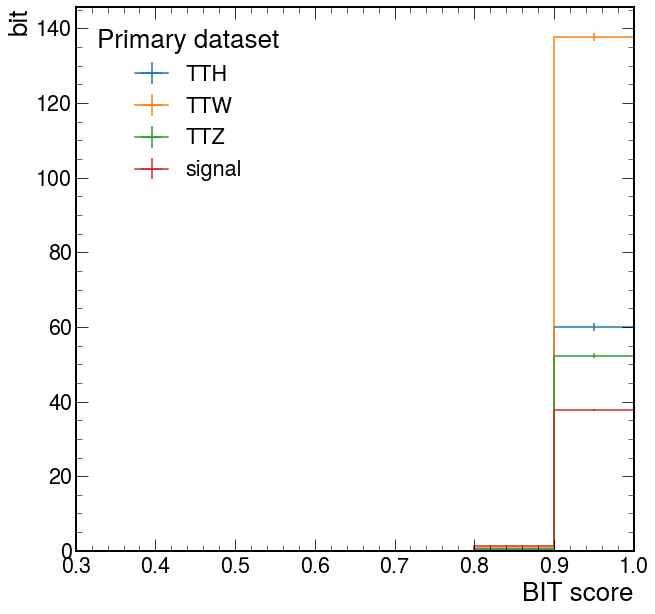

In [228]:
hist.plot1d(hist_dict['SR'])
hist.plot1d(sig_bit_hist_BSM)

<AxesSubplot:xlabel='BIT score', ylabel='bit'>

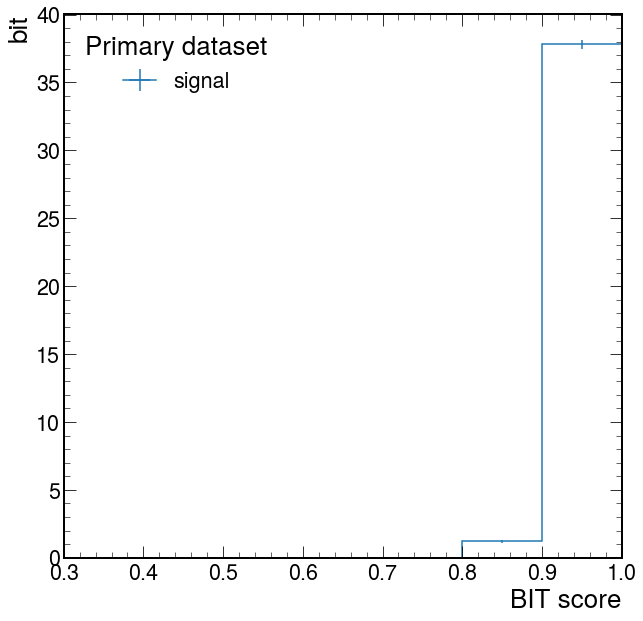

In [226]:
hist.plot1d(sig_bit_hist_BSM)

In [220]:
sm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_SM',
                signal_hist=sig_bit_hist_SM,
            )

bsm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_BSM',
                signal_hist=sig_bit_hist_BSM,
            )

Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       40.48
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_SM_card.txt
Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       72.35
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_BSM_card.txt


In [221]:
res_sm = card.calcNLL(sm_card)
res_bsm = card.calcNLL(bsm_card)

Creating /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/58227896-b38c-4361-8111-1a056f92ea87
 <<< Combine >>> 
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Channel Bin0 will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binBin0
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          0.003995        0.003547        total sum                     
0          0.003514        0.003514        excluding marked processes    
0          1.000000        1.000000        Unweighted events, alpha=0.003995
  => Total parameter prop_binBin0_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          0.026700        0.013246        total sum                     
1          0.026700        0.013246        excluding marked processes    
1       

      => Poisson not viable, prop_binBin0_bin9_TTZ[0.00,-7.00,7.00] to be gaussian constrained
  ----------------------------------------------------------
    signal               0.010112        0.006524                                      
                         2.000000        1.414214        Unweighted events, alpha=0.005056
      => Parameter prop_binBin0_bin9_signal[0.00,-7.00,7.00] to be gaussian constrained
  ----------------------------------------------------------
    TTH                  0.000000        0.000000                                      
      => Error is zero, ignore      
  ----------------------------------------------------------
    TTW                  0.004874        0.009473                                      
      => Poisson not viable, prop_binBin0_bin9_TTW[0.00,-7.00,7.00] to be gaussian constrained
  ----------------------------------------------------------
------------------------------------------------------------
Set Default Value of Para

In [222]:
deltaNLL = -2*(res_sm['nll0'][0]+res_sm['nll'][0] - (res_bsm['nll0'][0]+res_bsm['nll'][0]))
deltaNLL

9.846199127624686

In [238]:
def get_nll_bit(cpt, cpqm, signal, bkg):
    
    bit_axis     = hist.Bin("bit",     r"BIT score",  [0.,0.35,0.45,0.50,0.55,0.60,1.0])
    
    ttW = bkg[bkg['label']==1]
    ttZ = bkg[bkg['label']==2]
    ttH = bkg[bkg['label']==3]
    
    bit_hist = hist.Hist("bit", dataset_axis, bit_axis)
    bit_hist.fill(
        dataset="TTW",
        bit = ttW['pred_3'].values + ttW['pred_5'].values,
        weight=ttW['weight']*2,
    )
    bit_hist.fill(
        dataset="TTZ",
        bit = ttZ['pred_3'].values + ttZ['pred_5'].values,
        weight=ttZ['weight']*2,
    )
    bit_hist.fill(
        dataset="TTH",
        bit = ttH['pred_3'].values + ttH['pred_5'].values,
        weight=ttH['weight']*2,
    )

    hist_dict = {'SR': bit_hist}

    sig_bit_hist_SM = hist.Hist("bit", dataset_axis, bit_axis)
    sig_bit_hist_SM.fill(
        dataset='signal',
        bit = signal['pred_3'].values + signal['pred_5'].values,
        weight = signal['weight'],
    )

    sig_bit_hist_BSM = hist.Hist("bit", dataset_axis, bit_axis)
    sig_bit_hist_BSM.fill(
        dataset='signal',
        bit = signal['pred_3'].values + signal['pred_5'].values,
        weight=signal['weight']*hp.eval(coeffs.transpose(), [cpt,cpqm]),
    )
    
    sm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_SM',
                signal_hist=sig_bit_hist_SM,
            )

    bsm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_BSM',
                signal_hist=sig_bit_hist_BSM,
            )

    res_sm = card.calcNLL(sm_card);
    res_bsm = card.calcNLL(bsm_card);
    
    deltaNLL = -2*(res_sm['nll0'][0]+res_sm['nll'][0] - (res_bsm['nll0'][0]+res_bsm['nll'][0]))
    
    #cpt**2 * quad1 + cpqm**2 * quad2
    
    return deltaNLL

In [241]:
get_nll_bit(5,5, sig_test, bkg_test);

Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       40.48
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_SM_card.txt
Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       67.33
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_BSM_card.txt
Creating /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e84a9e3b-bf87-4735-950e-cdc92f570d9d
 <<< Combine >>> 
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Channel Bin0 wil

In [242]:
def get_nll_lt(cpt, cpqm, signal, bkg):
    
    lt_axis      = hist.Bin("lt",      r"$L_{T}$ (GeV)",   [100,200,300,400,500,600,700,2000])
    
    ttW = bkg[bkg['label']==1]
    ttZ = bkg[bkg['label']==2]
    ttH = bkg[bkg['label']==3]
    
    lt_hist = hist.Hist("bit", dataset_axis, lt_axis)
    lt_hist.fill(
        dataset="TTW",
        lt = ttW['lt'].values,
        weight=ttW['weight']*2,
    )
    lt_hist.fill(
        dataset="TTZ",
        lt = ttZ['lt'].values,
        weight=ttZ['weight']*2,
    )
    lt_hist.fill(
        dataset="TTH",
        lt = ttH['lt'].values,
        weight=ttH['weight']*2,
    )

    hist_dict = {'SR':lt_hist}

    sig_lt_hist_SM = hist.Hist("bit", dataset_axis, lt_axis)
    sig_lt_hist_SM.fill(
        dataset='signal',
        lt = signal['lt'].values,
        weight = signal['weight'],
    )

    sig_lt_hist_BSM = hist.Hist("bit", dataset_axis, lt_axis)
    sig_lt_hist_BSM.fill(
        dataset='signal',
        lt = signal['lt'].values,
        weight=signal['weight']*hp.eval(coeffs.transpose(), [cpt,cpqm]),
    )
    
    sm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_SM',
                signal_hist=sig_lt_hist_SM,
            )

    bsm_card = makeCardFromHist(
                hist_dict,
                'SR',
                overflow='all',
                ext='_BSM',
                signal_hist=sig_lt_hist_BSM,
            )

    res_sm = card.calcNLL(sm_card);
    res_bsm = card.calcNLL(bsm_card);
    
    deltaNLL = -2*(res_sm['nll0'][0]+res_sm['nll'][0] - (res_bsm['nll0'][0]+res_bsm['nll'][0]))
        
    return deltaNLL

In [245]:
get_nll_lt(5,5, sig_test, bkg_test)

Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       40.48
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_SM_card.txt
Writing cards using histogram: SR
Expectation for TTW:          193.11
Expectation for TTZ:          71.08
Expectation for TTH:          80.90
Expectation for signal:       67.33
Observation:                  345.09
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_BSM_card.txt
Creating /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/f642f9f3-1099-43b1-a9b2-1bc395c3389b
 <<< Combine >>> 
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Channel Bin0 wil

12.894941374893847

In [205]:
res_bsm['nll0'][0]

234.83821076683958

In [207]:
res_bsm['nll'][0]

-1.7558713132380888

# BIT example

In [87]:
data_dir = '../BIT/data/'
def load_data(name):
    return np.loadtxt('%s/%s.txt.gz' % (data_dir, name))

features = load_data('training_features_power_law_model')
features = features.reshape(features.shape[0], -1)
weights = load_data('training_weights_power_law_model')
diffs = load_data('training_diff_weights_power_law_model')

In [123]:
n_trees       = 100
learning_rate = 0.2 
max_depth     = 2
min_size      = 50
calibrated    = False

In [164]:
len(weights)

100000

In [124]:
bit = BoostedInformationTree(
        training_features     = features,
        training_weights      = weights, 
        training_diff_weights = diffs, 
        learning_rate         = learning_rate, 
        n_trees               = n_trees,
        max_depth             = max_depth,
        min_size              = min_size,
        calibrated            = True)

bit.boost()


[                    --------------------]
weak learner time: 5.59
update time: 5.43
calibration time: 0.12


In [133]:
Hist1D(diffs)

[10.00 ± 3.16   16.00 ± 4.00    9.00 ± 3.00   13.00 ± 3.61   18.00 ± 4.24
 11.00 ± 3.32   15.00 ± 3.87   17.00 ± 4.12   16.00 ± 4.00   11.00 ± 3.32
 18.00 ± 4.24   14.00 ± 3.74   20.00 ± 4.47   13.00 ± 3.61   37.00 ± 6.08
 19.00 ± 4.36   16.00 ± 4.00   28.00 ± 5.29   29.00 ± 5.39   19.00 ± 4.36
 42.00 ± 6.48   34.00 ± 5.83   23.00 ± 4.80   31.00 ± 5.57   25.00 ± 5.00
 42.00 ± 6.48   46.00 ± 6.78   44.00 ± 6.63   51.00 ± 7.14   41.00 ± 6.40
 39.00 ± 6.24   67.00 ± 8.19   44.00 ± 6.63   43.00 ± 6.56   51.00 ± 7.14
 45.00 ± 6.71   58.00 ± 7.62   72.00 ± 8.49   75.00 ± 8.66   84.00 ± 9.17
 73.00 ± 8.54   75.00 ± 8.66   89.00 ± 9.43   87.00 ± 9.33
 100.00 ± 10.00   94.00 ± 9.70   93.00 ± 9.64   108.00 ± 10.39
 109.00 ± 10.44   108.00 ± 10.39   116.00 ± 10.77   141.00 ± 11.87
 125.00 ± 11.18   119.00 ± 10.91   142.00 ± 11.92   125.00 ± 11.18
 163.00 ± 12.77   148.00 ± 12.17   197.00 ± 14.04   150.00 ± 12.25
 150.00 ± 12.25   187.00 ± 13.67   220.00 ± 14.83   200.00 ± 14.14
 228.00 ± 15.10   216.00 ± 14.70   262.00 ± 16.19   262.00 ± 16.19
 285.00 ± 16.88   313.00 ± 17.69   300.00 ± 17.32   297.00 ± 17.23
 309.00 ± 17.58   334.00 ± 18.28   410.00 ± 20.25   400.00 ± 20.00
 370.00 ± 19.24   377.00 ± 19.42   422.00 ± 20.54   462.00 ± 21.49
 466.00 ± 21.59   492.00 ± 22.18   523.00 ± 22.87   508.00 ± 22.54
 631.00 ± 25.12   595.00 ± 24.39   652.00 ± 25.53   634.00 ± 25.18
 688.00 ± 26.23   705.00 ± 26.55   842.00 ± 29.02   799.00 ± 28.27
 827.00 ± 28.76   914.00 ± 30.23   954.00 ± 30.89   997.00 ± 31.58
 997.00 ± 31.58   1120.00 ± 33.47   1179.00 ± 34.34   1148.00 ± 33.88
 1234.00 ± 35.13   1282.00 ± 35.81   1349.00 ± 36.73   1405.00 ± 37.48
 1391.00 ± 37.30   1555.00 ± 39.43   1679.00 ± 40.98   1706.00 ± 41.30
 1768.00 ± 42.05   1814.00 ± 42.59   1974.00 ± 44.43   2084.00 ± 45.65
 2195.00 ± 46.85   2271.00 ± 47.66   2408.00 ± 49.07   2512.00 ± 50.12
 2714.00 ± 52.10   2742.00 ± 52.36   2869.00 ± 53.56   3083.00 ± 55.52
 3104.00 ± 55.71   3240.00 ± 56.92   3485.00 ± 59.03   3650.00 ± 60.42
 3935.00 ± 62.73   4202.00 ± 64.82   4124.00 ± 64.22   4368.00 ± 66.09
 4514.00 ± 67.19]

In [128]:
test_feat = load_data('test_features_power_law_model')
test_feat = test_feat.reshape(test_feat.shape[0], -1)

pred = bit.vectorized_predict(test_feat) # returns all predictions

In [132]:
sig_h = Hist1D(pred, bins="20,0,1.2")
sig_h

[223.00 ± 14.93   161.00 ± 12.69   335.00 ± 18.30   189.00 ± 13.75
 516.00 ± 22.72   739.00 ± 27.18   841.00 ± 29.00   1811.00 ± 42.56
 3018.00 ± 54.94    0.00 ± 0.00   5907.00 ± 76.86   7687.00 ± 87.68
 6683.00 ± 81.75   7717.00 ± 87.85   17770.00 ± 133.30   21062.00 ± 145.13
 25341.00 ± 159.19    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00]